In [1]:
import numpy as np
import polytope as pc
from itertools import combinations

import matplotlib.pyplot as plt

import sys
sys.path.append('../')

from best.abstraction import LTIAbstraction
from best.mdp import *
from best.policy import *

from Models.Linear import LTI

# Define the linear time invariant system
#A = np.array([[0,-0.8572],[0.1,0.5]])
dim = 2
A = np.eye(2) #np.array([[.9,-0.32],[0.1,0.9]])
B = np.eye(dim)  #array([[1], [0.1]])
W = np.array([[0,0],[0,0.4]]) #2*Tr.dot(np.eye(dim)).dot(Tr)  # noise on transitions
 
# Accuracy
C = np.array([[1, 0],[0,1]])  # defines metric for error (||y_finite-y||< epsilon with y= cx   )

sys_lti = LTI(A, B, C, None, W=W)  # LTI system with   D = None
sys_lti.setU(pc.box2poly(np.kron(np.ones((sys_lti.m, 1)), np.array([[-1, 1]])))) # continuous set of inputs
sys_lti.setX(pc.box2poly(np.kron(np.ones((sys_lti.dim, 1)), np.array([[-10, 10]])))) # X space

In [2]:
# Define regions of interest for the labeling
regions = dict()
regions['target1'] = pc.box2poly(np.array([[-9, -6], [6, 9]]))
# add avoid
regions['target2'] = pc.box2poly(np.array([[6, 9], [6, 9]]))

In [3]:
## step 1: tune gridding ratio (find optimal horizontal d_1, and vertical d_2)
# currently only available for 2D
# d_opt, d_vals, eps_values = tune_dratio(sys_n)

d_opt = np.array([[ 0.69294],
                  [ 0.721  ]])

# d = np.array([[1.5], [1.5]])
d = d_opt

### Construct map MDP

In [4]:
p1 = 0.5
p2 = 0.6

T0 = np.eye(3)
T1 = np.array([[0,p1,1-p1], [0,1,0], [0,0,1]])
T2 = np.array([[0,p2,1-p2], [0,1,0], [0,0,1]])

def output_fcn(n):
    if n == 0:
        return 'init'    # label unknown
    if n == 1:
        return 'sample'  # there is a sample
    if n == 2:
        return 'empty'   # no sample
    
map1 = MDP([T0, T1], input_name='meas1',
                     output_fcn=output_fcn, output_name='samplelabel1')

map2 = MDP([T0, T2], input_name='meas2',
                     output_fcn=output_fcn, output_name='samplelabel2')

map_mdp = ParallelMDP([map1, map2])
print map_mdp

MDP: 4 inputs "(meas1, meas2)" --> 9 states "(samplelabel1, samplelabel2)"


### Construct abstraction

Warning no inputspace given
Warning no state space given
status: optimal
optimal epsilon 1.00000639831
optimal M [[ 1.  0.]
 [ 0.  1.]]
Optimal K [[ 0. -1.]
 [-1.  0.]]
('check norm of rows', matrix([[ 0.,  1.],
        [-1.,  0.],
        [ 0., -1.],
        [ 1.,  0.]]))
('check norm of rows', matrix([[ 0.,  1.],
        [-1.,  0.],
        [ 0., -1.],
        [ 1.,  0.]]))
MDP: 16 inputs "u_d" --> 871 states "(s, x_d)"


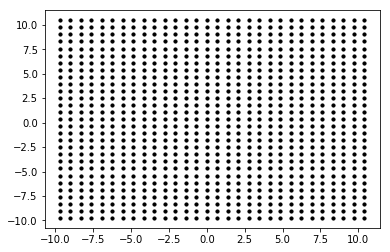

In [5]:
# mdp_grid = sys_n.abstract_io(d, un=4, verbose=False)  # do the gridding
# mdp_grid.map_dfa_inputs(dict_input2prop, regions)

abstr = LTIAbstraction(sys_lti, d, un=4)
abstr.set_regions(regions)

in_regions, nin_regions = abstr.map_dfa_inputs()

fig = plt.figure()
abstr.plot(fig)
print abstr.mdp

### Connect abstraction and map

In [6]:
# mapping (s, x_d) -> (meas1, meas2)
def map_connection(s_xd):
    if s_xd[0] == abstr.mdp.N-1:
        return set([(0,0)])
    
    x_d = np.array(s_xd[1]).reshape((2,1))
        
    ret = [0 for i in range(len(regions))]
    for i, poly in enumerate(regions.itervalues()):
        if poly.contains(x_d):
            ret[i] = 1
    return set([tuple(ret)])

prod_mdp = ProductMDP(abstr.mdp, map_mdp, map_connection)
print prod_mdp

set([(0, 0)])
set([(1, 0)])
set([(0, 1)])
MDP: 16 inputs "u_d" --> 7839 states "((s, x_d), (samplelabel1, samplelabel2))"


### Set up LTL problem

In [7]:
print np.nonzero(nin_regions['target1']==0)
print np.nonzero(nin_regions['target2']==0)
print abstr.mdp.output(728)
print abstr.mdp.output(749)

(array([728]), array([0]))
(array([749]), array([0]))
(728, array([[-7.5705 ],
       [ 7.62234]]))
(749, array([[ 7.5705 ],
       [ 7.62234]]))


In [8]:
formula = '( F sample )'

def subsets(collection):
    for i in range(len(collection)+1):
        it = combinations(collection, i)
        try:
            while True:
                yield(list(next(it)))
        except StopIteration:
            pass
    raise StopIteration

def get_regions(s):
    '''compute subsets of possible regions corresponding to abstract state'''   
    if s == abstr.mdp.N-1:
        return set([ (), ])
    
    know_in = []
    know_out = []
    for reg in regions.keys():
        if in_regions[reg][s] == 0:
            know_out.append(reg)
        if nin_regions[reg][s] == 0:
            know_in.append(reg)
    uncertain = list(set(regions.keys()) - set(know_in) - set(know_out))
    return set([ tuple(know_in + unc) for unc in subsets(uncertain)])  

# map ((s, xd), (sample1, sample2)) -> 2^{sample}
def abstract_connection(s_xd_sample):
    s = s_xd_sample[0][0]
    regions = get_regions(s)
    
    sample1 = s_xd_sample[1][0]
    sample2 = s_xd_sample[1][1]

    if all('target1' in reg for reg in regions) and sample1 == 'sample' or \
       all('target2' in reg for reg in regions) and sample2 == 'sample':
        return set([tuple(['sample'])])
    else:
        return set([(), ])

print abstract_connection( ( (728, (_, _)), ('sample', 'empty') ) )
print abstract_connection( ( (728, (_, _)), ('empty', 'empty') ) )

print abstract_connection( ( (749, (_, _)), ('empty', 'sample') ) )
print abstract_connection( ( (749, (_, _)), ('empty', 'empty') ) )

set([('sample',)])
set([()])
set([('sample',)])
set([()])


### Solve with Petter's recursion

In [9]:
import best.policy as bp
from best.ltl import formula_to_mdp

reload(bp)

dfsa, init, final, _ = formula_to_mdp(formula)
mdp_dfsa = ProductMDP(prod_mdp, dfsa, abstract_connection)
print mdp_dfsa

V, pol = mdp_dfsa.solve_reach(accept=lambda s: s[1] in final)

pol_qn = pol.reshape( (dfsa.N, prod_mdp.N), order='F' )
V_qn = V.reshape( (dfsa.N, prod_mdp.N), order='F' )

pol_pn = bp.LTL_Policy(dfsa, list(init)[0], final, pol_qn, V_qn)

MDP: 16 inputs "u_d" --> 15678 states "(((s, x_d), (samplelabel1, samplelabel2)), mu)"
iteration 0, time 4.05311584473e-06
iteration 1, time 729.331240177
iteration 2, time 729.379991055
iteration 3, time 729.406613111
iteration 4, time 729.429795027
iteration 5, time 729.453698158
iteration 6, time 729.475414038
iteration 7, time 729.496597052
iteration 8, time 729.51762104
iteration 9, time 729.544834137
iteration 10, time 729.570142984
iteration 11, time 729.595479012
iteration 12, time 729.619222164
iteration 13, time 729.641448021
iteration 14, time 729.664016008
iteration 15, time 729.686784983
iteration 16, time 729.709309101
iteration 17, time 729.732248068
iteration 18, time 729.76028204
iteration 19, time 729.786061049
iteration 20, time 729.809571028
iteration 21, time 729.833001137
iteration 22, time 729.856142998
iteration 23, time 729.878211975
iteration 24, time 729.90071106
iteration 25, time 729.926759958
iteration 26, time 729.952006102
iteration 27, time 729.97763705

### Solve with Sofie's recursion

In [29]:
from best.bellman import reach_dfa

dfsa, dfsa_init, dfsa_final, _ = formula_to_mdp(formula)

act_inputs = np.array([[1 if q in map(dfsa.input, abstract_connection( prod_mdp.output(s) )) else 0 
                        for s in range(prod_mdp.N)] for q in range(dfsa.N)])
act_inputs[:,-1] = 0

V, pol_mat, W = reach_dfa(act_inputs, prod_mdp, dfsa, dfsa_final, V=None, recursions=30, delta=0.0)
pol_sof = LTL_Policy(dfsa, list(dfsa_init)[0], dfsa_final, pol_mat, V)

### Define policy

In [30]:
pol = pol_sof

# define a policy on top of mdp policy
def my_policy(x, sam1, sam2):
    # x: current concrete state [x; y]
    # sam1: current state of target1 {0,1,2}
    # sam2: current state of target2 {0,1,2}
    x = np.array(x).reshape((2,1))
    
    if regions['target1'].contains(x) and sam1 == 1 or \
       regions['target2'].contains(x) and sam2 == 1:
        aps = set(['sample'])
    else:
        aps = set([])
    pol.report_aps(aps)
    
    s_abstract = abstr.closest_abstract(x)
    
    s_tot = prod_mdp.global_state((s_abstract, (sam1, sam2) ))
   
    u_abstract, curr_val = pol.get_input(s_tot)
    
    return abstr.refine_input(u_abstract, s_abstract, x)

def my_value(x):    
    x = np.array(x).reshape((2,1))
    
    s_abstract = abstr.closest_abstract(x)
    s_tot = prod_mdp.global_state( (s_abstract, (0,0)) )

    return pol.V[list(dfsa_init)[0], s_tot]

def my_policy_init(x):
    u = my_policy(x, 0,0)
    pol.reset()
    return u


6. Plot concrete systen


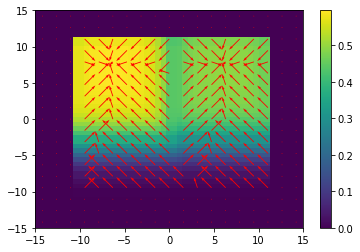

In [31]:
print('6. Plot concrete systen')
fig = plt.figure()
x_edge = np.linspace(-15,15,50)
x_del = np.diff(x_edge).max()
y_edge = np.linspace(-15,15,50)
y_del = np.diff(y_edge).max()

xi, yi = np.meshgrid(x_edge[:-1]+x_del/2,y_edge[:-1]+y_del/2)
xi = xi.flatten()
yi = yi.flatten()

values = np.array([my_value((x,y)) for (x,y) in zip(xi, yi)])


plt.pcolor(x_edge, y_edge, values.reshape((49,49)))
plt.colorbar()
plt.xlim(np.array([-15,15]))
plt.ylim(np.array([-15,15]))

x_edge = np.linspace(-15,15,20)
x_del = np.diff(x_edge).max()
y_edge = np.linspace(-15,15,20)
y_del = np.diff(y_edge).max()

xi, yi = np.meshgrid(x_edge[:-1]+x_del/2,y_edge[:-1]+y_del/2)
xi = xi.flatten()
yi = yi.flatten()

delx_fun = lambda x,y: sys_lti.a.dot(np.array([[x], [y]])) + sys_lti.b.dot(my_policy_init((x,y))) - np.array([[x], [y]])

delx = np.hstack([delx_fun(x,y) for (x,y) in zip(xi, yi)])

x_tr = (np.block([[xi.flatten()], [yi.flatten()]]))

#plt.quiver(xi.flatten(), yi.flatten(),u[0],u[1])
plt.quiver(xi, yi, delx[0], delx[1], color = 'r')


In [ ]:
pol_sof.V[1,:][prod_mdp.global_state((200, (0,0)) )]

In [ ]:
print prod_mdp.global_state((200, (0,0)) )
print prod_mdp.local_states(1800)
print prod_mdp.output(1800)

In [ ]:
list(dfsa_init)[0],